**Handmade GARCH model**


Paulo Yoshio Kuga

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import bandeirante as bd
from scipy.signal import argrelextrema
import numpy as np

from sklearn.decomposition import PCA

import yfinance as yf

from datetime import datetime,timedelta

Leitor de dados da B3

In [2]:
start_date = datetime(2021,1,1)
end_date = datetime.today()

ticker = "BOVA11.SA"

dataset = yf.download(
    ticker,
    start=start_date,
    end=end_date,
    auto_adjust=False,
    interval="1d"
    ).droplevel(axis=1,level=1)


[*********************100%***********************]  1 of 1 completed


In [136]:
retornos = dataset["Close"].pct_change().add(1).apply(np.log).dropna()

retornos_var = retornos.rolling(20).var().dropna()
retornos_2 = retornos.loc[retornos_var.index].pow(2)

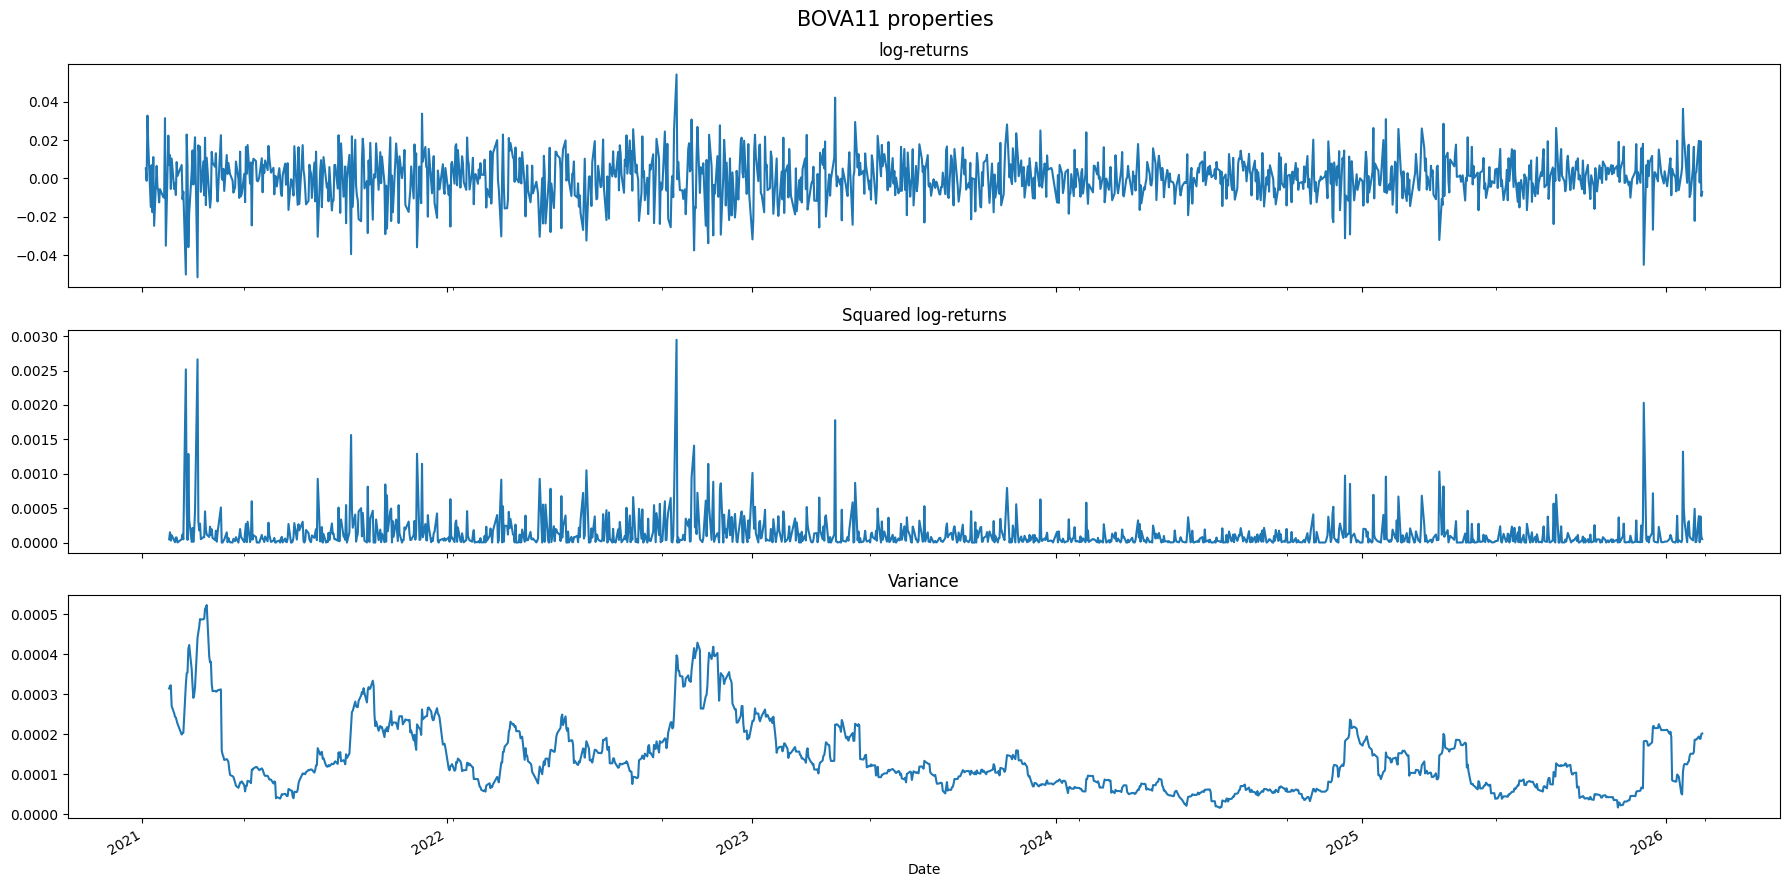

In [137]:
fig,axs = plt.subplots(3,1, figsize=(18,9),sharex=True)

retornos.plot(ax=axs[0])
retornos_2.plot(ax=axs[1])
retornos_var.plot(ax=axs[2])


fig.suptitle("BOVA11 properties",fontsize=15)

axs[0].set_title("log-returns")
axs[1].set_title("Squared log-returns")
axs[2].set_title("Variance")

fig.tight_layout()

In [ ]:
var_order = 5 #number of autoregressions
returns_order = 4

ret2_np = retornos_2.to_numpy()
var_np = retornos_var.to_numpy()

#creates hankel matrix
U = bd.hankel_matrix(ret2_np,returns_order)
H = bd.hankel_matrix(var_np,var_order)

#depending on the orders, we need to separate only pertinent values
if var_order > returns_order:
    U = U[var_order-returns_order:]
elif var_order < returns_order:
    H = H[returns_order-var_order:]


#offset vector of ones
offset_vector = np.ones(U.shape[0]).reshape(-1,1)

#input data
X = np.concat([offset_vector,H,U],axis=1)



In [ ]:
window_target = 5 #how many days ahead we want to predict

roll_w = window_target+var_order #the effective window in the roll operation

y = np.roll(var_np,-(roll_w))[:-roll_w] #


In [154]:
#values to autoregression
series_length, = y.shape

train_test_percentual = 0.8

cut_value = int(np.ceil((series_length*train_test_percentual)))

X_train, X_test = (X[:cut_value],X[cut_value:])
y_train, y_test = (y[:cut_value],y[cut_value:])


In [155]:
A = X_train.T@X_train

b = X_train.T@y_train


theta = np.linalg.solve(A,b)
text_to_display = [f"theta {i}: " + str(a) for i,a in enumerate(theta)]
print("autoreg parameters: \n " + " \n ".join(text_to_display))

autoreg parameters: 
 theta 0: 1.4241696310862767e-05 
 theta 1: 0.5713195235558257 
 theta 2: -0.028052758068386186 
 theta 3: -0.11830205663766856 
 theta 4: 0.01893611520640588 
 theta 5: 0.3295589728528331 
 theta 6: 0.026747622589409752 
 theta 7: 0.027039686494773372 
 theta 8: 0.036198601512062514 
 theta 9: 0.03424099635900159


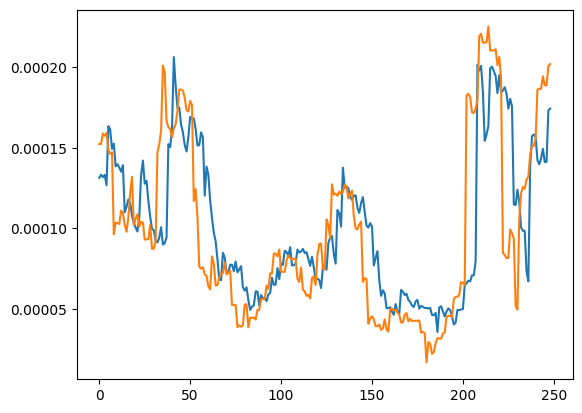

In [163]:
y_pred = X_test[:-window_target]@theta

plt.plot(y_pred)

plt.plot(y_test)

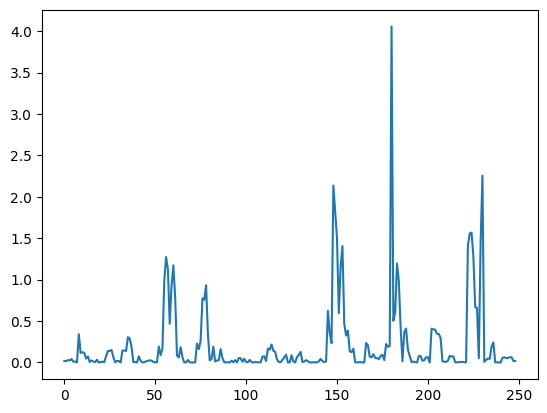

In [ ]:
residual = np.pow((y_pred-y_test)/y_test,2)

plt.plot(residual)